In [1]:
import sys
sys.path.append('/Users/nwilming/u')
import cPickle
from conf_analysis.pupil import pupil, patsy_transforms as pt
from conf_analysis.behavior import empirical
from pylab import *
import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')

/Users/nwilming/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = empirical.load_data()
data = empirical.data_cleanup(data)

In [4]:
try:
    mlab.stop()
except Exception:
    pass

from pymatbridge import Matlab

mlab = Matlab(executable='/Applications/MATLAB_R2014a.app/bin/matlab')

mlab.start()
_=mlab.run_code("addpath('/Users/nwilming/u/HMM/')")


/Users/nwilming/anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-f12e2aca-c9f2-41d5-8e99-5665e32e657b
Send 'exit' command to kill the server
.........MATLAB started and connected!


In [5]:
 S1 = list((data.query('response==-1').groupby('snum').apply(lambda x:
           x.groupby(['side', 'confidence'])
           .response.sum().loc[[(-1, 2), (-1, 1), (1, 1), (1, 2)]].values)).values)
 S2 = list((data.query('response==1').groupby('snum').apply(lambda x:
       x.groupby(['side', 'confidence'])
       .response.sum().loc[[(-1, 2), (-1, 1), (1, 1), (1, 2)]].values)).values)

In [182]:
S1

[array([-331., -467., -261., -122.]),
 array([-201., -559., -169.,  -21.]),
 array([-589., -364., -168.,  -75.]),
 array([-444., -444., -193.,  -88.]),
 array([-208., -674., -236.,  -10.]),
 array([-415., -408., -202.,  -90.]),
 array([-275., -502.,  -78.,  -32.]),
 array([-435., -458., -202., -106.]),
 array([-445., -401., -134.,  -99.]),
 array([-251., -373.,  -63.,  -53.]),
 array([-196., -640., -202.,   -5.]),
 array([-128., -628., -198.,  -13.]),
 array([-230., -618., -160.,  -20.]),
 array([-325., -424., -138.,  -60.]),
 array([-521., -393., -174., -145.])]

In [9]:
import h5py
try:
    fit.file.close()
except IOError:
    pass
except NameError:
    pass
fit = h5py.File('/Users/nwilming/u/conf_analysis/hmm_metad_model_fit.mat')['fit']

(20000, 5)


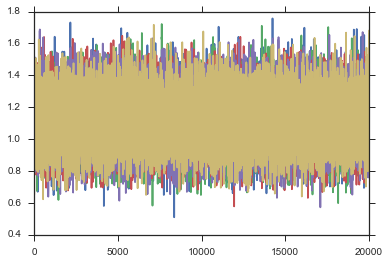

In [10]:
k = fit['mcmc']['samples']['Mratio_rS2']
print k[1,:,:].shape
plot(k[1,:,:])

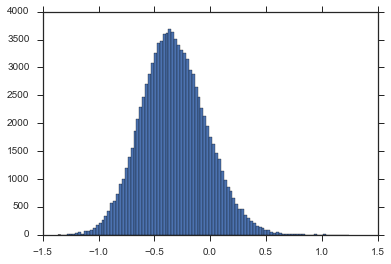

In [196]:
larger = sum(fit['mcmc']['samples']['mu_logMratio_rS1'][:].ravel()>fit['mcmc']['samples']['mu_logMratio_rS2'][:].ravel())
larger/float(len(fit['mcmc']['samples']['mu_logMratio_rS1'][:].ravel()))

_= hist(fit['mcmc']['samples']['mu_logMratio_rS1'][:].ravel()-fit['mcmc']['samples']['mu_logMratio_rS2'][:].ravel(), bins=100)


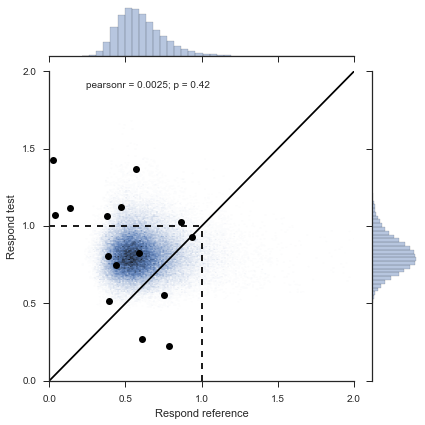

In [183]:
g = sns.jointplot(exp(fit['mcmc']['samples']['mu_logMratio_rS1'][:].ravel()), 
                  exp(fit['mcmc']['samples']['mu_logMratio_rS2'][:].ravel()),
             kind='hexbin')
g.ax_joint.plot([0, 2], [0,2], 'k')
g.ax_joint.plot([0, 1], [1,1], '--k')
g.ax_joint.plot([1, 1], [0,1], '--k')
g.set_axis_labels('Respond reference', 'Respond test')
g.ax_joint.set_xlim([0, 2])
g.ax_joint.set_ylim([0, 2])
sr1 = fit['Mratio_rS1'][:]
sr2 = fit['Mratio_rS2'][:]
_ = g.ax_joint.plot(sr1, sr2, 'ko')
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/meta_dprime.png', bbox_to_anchor='tight', dpi=600)

Compute 'classic' type II d'
==========================

For a classic type II d' analysis one computes wether confidence can separat between correct and incorrect responses. 

|   | High Conf | Low Conf. |
|:---|:---|:---|
|*Correct* | Hit |  Miss |
|*Error* | False Alarm |  Correct rejection |

For a type II SDI analysis we use the following table:

|   | High Conf | Low Conf. |
|:---|:---|:---|
|*Correct rejection* | Hit |  Miss |
|*Miss* | False Alarm |  Correct rejection |

In [117]:
print empirical.tbl(data.query('response==-1'))
empirical.tbl(data)

(0.0, 0.0, 0.99971574758385451, 0.99991901522513771)


(0.8097555699762059,
 0.33239619377162632,
 0.19019035258490158,
 0.66754974048442905)

In [166]:
from scipy.stats import norm 
def phi(x):
    '''
    Inverse cumulative normal
    '''
    return norm.ppf(x)


def type2_tbl(data):
    hit = len(data.query('correct==1 & confidence==2'))
    miss = len(data.query('correct==1 & confidence==1'))
    fa = len(data.query('correct==0 & confidence==2'))
    cr = len(data.query('correct==0 & confidence==1'))
    return float(hit) / (hit+miss), float(fa) / (cr+fa), float(cr) / (cr+fa), float(miss) / (hit+miss)


def type2_SDI_tbl(data):
    crs = data.query('response==-1 & side==-1')
    misses = data.query('response==-1 & side==1')    
    hit = len(crs.query('confidence==2'))
    miss = len(crs.query('confidence==1'))
    fa = len(misses.query('confidence==2'))
    cr = len(misses.query('confidence==1'))
    return float(hit) / (hit+miss), float(fa) / (cr+fa), float(cr) / (cr+fa), float(miss) / (hit+miss)


def SDI_AUC(data, response=-1):
    crs = [0]
    misses = [0]
    data = data.query('response==%i'%response)
    for c in unique(data.confidence.dropna()):
        cd = data.query('confidence<=%i'%c)
        miss = float(len(cd.query('side==%i'%(-response)))) / len(data.query('side==%i'%(response)))
        cr = float(len(cd.query('side==%i'%(response))))/len(data.query('side==%i'%(response)))
        crs.append(cr)
        misses.append(miss)
    return np.trapz(misses, crs)



def dp(data, tbl=type2_tbl):
    '''
    compute d'
    '''
    hit, fa, _, _ = tbl(data)
    if hit==1 or fa==1:
        raise RuntimeError('Too good or too bad')
    return phi(hit) - phi(fa)



In [156]:
k = data.groupby(['snum', 'noise_sigma', 'response']).apply(lambda x: dp(x, tbl=type2_tbl))
k.name='dp'
k = k.reset_index()

In [157]:
kc = data.groupby(['snum', 'noise_sigma', 'response']).apply(lambda x: empirical.crit(x))
kc.name='crit'
kc = kc.reset_index()

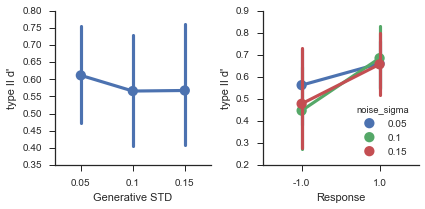

In [159]:
figure(figsize=(6,3))
subplot(1,2,1)
sns.pointplot(x='noise_sigma', y='dp', units='snum', ci=95, data=k)
ylabel('type II d\'')
xlabel('Generative STD')
subplot(1,2,2)
sns.pointplot(x='response', y='dp', hue='noise_sigma', units='snum', ci=95, data=k)
ylabel('type II d\'')
xlabel('Response')
sns.despine()
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/typeII_dprime.pdf')

In [171]:
k = data.groupby(['snum', 'noise_sigma']).apply(lambda x: SDI_AUC(x))
k.name='SDI_R'
k = k.reset_index()
k2 = data.groupby(['snum', 'noise_sigma']).apply(lambda x: SDI_AUC(x, response=1))
k2.name='SDI'
k.loc[:, 'SDI_D'] = k2.reset_index().loc[:, 'SDI']

In [179]:
k.stack()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
snum,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,4.000000,...,12.000000,13.000000,13.000000,13.000000,14.000000,14.000000,14.000000,15.000000,15.000000,15.000000
noise_sigma,0.050000,0.100000,0.150000,0.050000,0.100000,0.150000,0.050000,0.100000,0.150000,0.050000,...,0.150000,0.050000,0.100000,0.150000,0.050000,0.100000,0.150000,0.050000,0.100000,0.150000
SDI_R,0.308156,0.222612,0.257491,0.085614,0.141389,0.203938,0.200332,0.148135,0.143501,0.224733,...,0.090178,0.150848,0.085505,0.131165,0.223011,0.114995,0.096020,0.298125,0.148275,0.133358
SDI_D,0.206694,0.319794,0.331566,0.299853,0.309023,0.288903,0.228502,0.227488,0.325199,0.214288,...,0.302713,0.162566,0.197161,0.339380,0.265703,0.248993,0.358709,0.138241,0.192772,0.252493


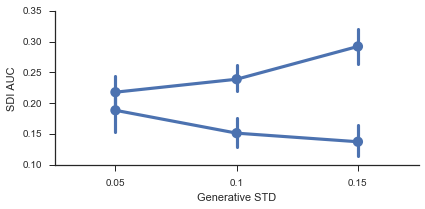

In [169]:
figure(figsize=(6,3))
sns.pointplot(x='noise_sigma', y='SDI', units='snum', ci=95, data=k)
ylabel('SDI AUC')
xlabel('Generative STD')
sns.despine()
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/typeII_SDI.pdf')